In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from hydra import initialize, compose

import time

import pytorch_lightning as pl

import torch
from torch import optim

from bliss.models import encoder, decoder, flux_net
from bliss.models.encoder import get_star_bool
from bliss.datasets import simulated

import plotting_utils 

device = "cuda:4"
print(device)

pl.seed_everything(2323)

Global seed set to 2323


cuda:4


2323

# Load dataset

In [2]:
overrides = {'model':"sleep_sdss_detection", 'dataset':'default'}
overrides = [f"{key}={value}" for key, value in overrides.items()]
with initialize(config_path="../../config"): # possibly change relative path to config folder here. 
    cfg = compose("config", overrides=overrides)

In [3]:
cfg.model.kwargs.decoder_kwargs.update({'prob_galaxy': 0., 
                                        'f_min': 1e3,
                                        'f_max': 1e5})

In [4]:
cfg.optimizer.kwargs.update({'lr': 0.001})

cfg.dataset.kwargs.update({'batch_size': 128})

In [5]:
# set device
cfg.dataset.kwargs.update({'generate_device': device})

In [6]:
dataset = simulated.SimulatedDataset(**cfg.dataset.kwargs)

In [7]:
cfg.training.n_epochs

121

### some sample images

In [8]:
test_dataloader = dataset.test_dataloader()

In [9]:
for _, batch in enumerate(test_dataloader):
    break

In [10]:
_true_tile_dict = dict(locs = batch['locs'],
                       n_sources = batch['n_sources'],
                       galaxy_bool = batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


In [11]:
def plot_params(params, indx, ax): 
    locs = params['locs'][indx].cpu() * dataset.image_decoder.slen + \
                dataset.image_decoder.border_padding - 0.5
    
    locs = locs[:, (1, 0)]

    n_sources = int(params['n_sources'][indx])
    galaxy_bool = params['galaxy_bool'][indx].squeeze(-1).cpu()    
    
    plotting_utils.plot_locations(locs, 
                                  galaxy_bool, 
                                  n = n_sources, 
                                  ax = ax)

In [12]:
%matplotlib inline

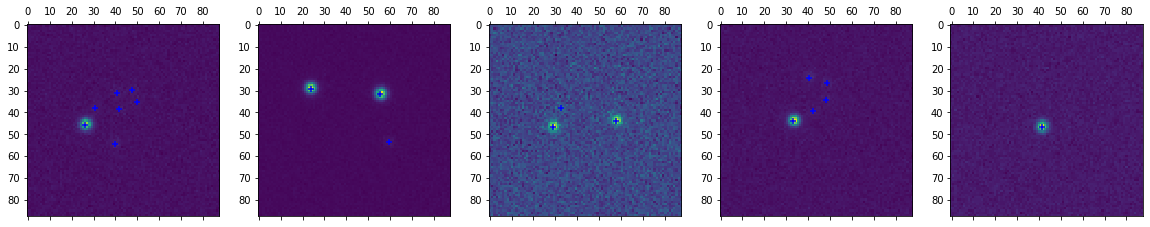

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))

for indx in range(batch['images'].shape[0]):
    
    if indx > 4: 
        break
        
    # plot image 
    axes[indx].matshow(batch['images'][indx, 0].cpu())

    # plot parameters
    plot_params(true_params, indx, axes[indx])

(array([317.,  25.,  15.,   7.,   5.,   3.,   6.,   3.,   6.,   3.]),
 array([ 1011.62634, 10780.7705 , 20549.916  , 30319.059  , 40088.203  ,
        49857.348  , 59626.492  , 69395.64   , 79164.78   , 88933.93   ,
        98703.07   ], dtype=float32),
 <BarContainer object of 10 artists>)

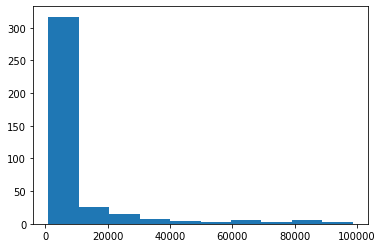

In [14]:
f = batch['fluxes'].flatten()
f = f[f > 0]

plt.hist(f.cpu().numpy())

# Define encoder

In [15]:
warm_start = False

In [16]:
if warm_start: 
    flux_checkpoint_file = '/home/runingli/astronomy/celeste/models/flux_net_single_tile.ckpt'
    flux_estimator = flux_net.FluxEstimator.load_from_checkpoint(flux_checkpoint_file, 
                                                               decoder_kwargs = cfg.model.kwargs.decoder_kwargs)
    flux_estimator.to(device);
else: 
    flux_estimator = flux_net.FluxEstimator(cfg.model.kwargs.decoder_kwargs, 
                                        optimizer_params=cfg.optimizer)
    flux_estimator.to(device);

conv_out_dim 16


### Initial loss

In [17]:
def eval_loss(): 
    loss = 0
    counter = 0
    target = 0

    for _, batch in enumerate(test_dataloader):
        
        # estimated loss
        loss += flux_estimator.get_loss(batch)

        # loss under the truth
        target += flux_estimator.kl_qp_flux_loss( 
                        batch,
                        batch['fluxes'], 
                        # set the sd to 1
                        batch['fluxes'] * 0. + 1.0)[0].mean()

        counter += 1
        
        break

    print('loss:   {}'.format(loss / counter))
    print('target: {}'.format(target / counter))

In [18]:
eval_loss()

tensor(0.0034, device='cuda:4', grad_fn=<MinBackward1>)
loss:   52327.68359375
target: 37184.28125


# Optimize

In [19]:
trainer = pl.Trainer(**cfg.training.trainer)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [20]:
t0 = time.time()
trainer.fit(flux_estimator, datamodule = dataset)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name          | Type           | Params
-------------------------------------------------
0 | image_decoder | ImageDecoder   | 6     
1 | enc           | FluxEncoderNet | 12.8 K
-------------------------------------------------
12.8 K    Trainable params
6         Non-trainable params
12.8 K    Total params
0.051     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

tensor(0.0015, device='cuda:0')
tensor(0.0023, device='cuda:0')


Global seed set to 2323


Training: 0it [00:00, ?it/s]

tensor(0.0015, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0050, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0032, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0092, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0477, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.1028, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.2922, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.2801, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.6008, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.7377, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.0190, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.2087, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.4943, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.8760, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2637, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.7754, device='cuda:0', grad_fn=<MinBackward1>)
tensor(3.3822, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.1616, device='cuda:0', grad_fn=<MinBack

Validating: 0it [00:00, ?it/s]

tensor(146.3365, device='cuda:0')
tensor(139.6333, device='cuda:0')
tensor(144.6469, device='cuda:0')
tensor(138.3598, device='cuda:0')
tensor(144.4768, device='cuda:0')
tensor(138.0353, device='cuda:0')
tensor(143.1435, device='cuda:0')
tensor(139.6044, device='cuda:0')
tensor(142.2849, device='cuda:0')
tensor(138.5379, device='cuda:0')
tensor(141.8006, device='cuda:0', grad_fn=<MinBackward1>)
tensor(130.2259, device='cuda:0', grad_fn=<MinBackward1>)
tensor(112.8559, device='cuda:0', grad_fn=<MinBackward1>)
tensor(100.2296, device='cuda:0', grad_fn=<MinBackward1>)
tensor(93.5065, device='cuda:0', grad_fn=<MinBackward1>)
tensor(74.5634, device='cuda:0', grad_fn=<MinBackward1>)
tensor(60.5289, device='cuda:0', grad_fn=<MinBackward1>)
tensor(48.7783, device='cuda:0', grad_fn=<MinBackward1>)
tensor(42.4747, device='cuda:0', grad_fn=<MinBackward1>)
tensor(25.0231, device='cuda:0', grad_fn=<MinBackward1>)
tensor(22.4333, device='cuda:0', grad_fn=<MinBackward1>)
tensor(17.4387, device='cuda:

Validating: 0it [00:00, ?it/s]

tensor(0.0771, device='cuda:0')
tensor(0.0771, device='cuda:0')
tensor(1.7235, device='cuda:0')
tensor(3.8319, device='cuda:0')
tensor(2.3293, device='cuda:0')
tensor(0.0771, device='cuda:0')
tensor(3.5255, device='cuda:0')
tensor(8.2062, device='cuda:0')
tensor(4.9612, device='cuda:0')
tensor(3.7914, device='cuda:0')
tensor(0.0771, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0771, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0770, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0770, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.5365, device='cuda:0', grad_fn=<MinBackward1>)
tensor(2.2788, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0770, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0769, device='cuda:0', grad_fn=<MinBackward1>)
tensor(7.1928, device='cuda:0', grad_fn=<MinBackward1>)
tensor(8.1822, device='cuda:0', grad_fn=<MinBackward1>)
tensor(4.2116, device='cuda:0', grad_fn=<MinBackward1>)
tensor(1.6378, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0

Validating: 0it [00:00, ?it/s]

tensor(0.0805, device='cuda:0')
tensor(5.2059, device='cuda:0')
tensor(0.0805, device='cuda:0')
tensor(0.0805, device='cuda:0')
tensor(0.0805, device='cuda:0')
tensor(0.1655, device='cuda:0')
tensor(0.0805, device='cuda:0')
tensor(0.0805, device='cuda:0')
tensor(3.2897, device='cuda:0')
tensor(0.0805, device='cuda:0')
tensor(0.6806, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0973, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0806, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0805, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0806, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0806, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0807, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0808, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0809, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0810, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0811, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0.0813, device='cuda:0', grad_fn=<MinBackward1>)
tensor(0

/home/runingli/anaconda3/envs/bliss_py/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn('Detected KeyboardInterrupt, attempting graceful shutdown...')


# Evaluate

In [21]:
flux_estimator.to(device);

In [22]:
for _, test_batch in enumerate(test_dataloader):
    break

In [23]:
# get estimates
out = flux_estimator(test_batch['images'])

# get loss
_, recon = flux_estimator.kl_qp_flux_loss(test_batch,
                                             out['mean'], 
                                             out['sd'])

tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)


In [24]:
_true_tile_dict = dict(locs = test_batch['locs'],
                       n_sources = test_batch['n_sources'],
                       galaxy_bool = test_batch['galaxy_bool'])
    
true_params = encoder.get_full_params(_true_tile_dict, dataset.image_decoder.slen)


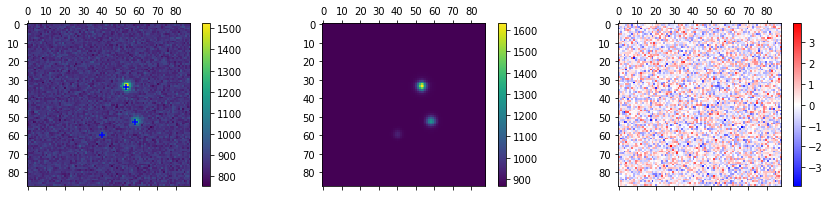

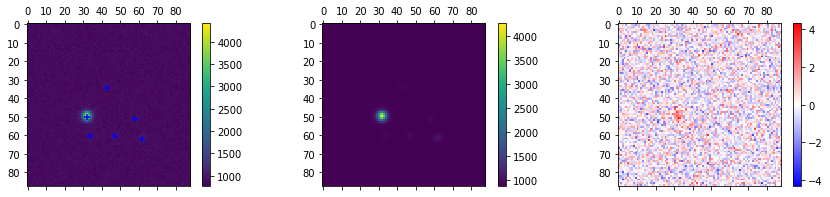

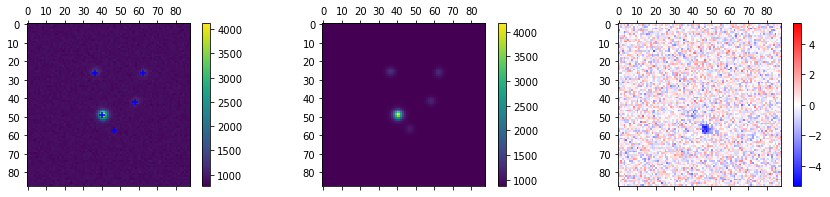

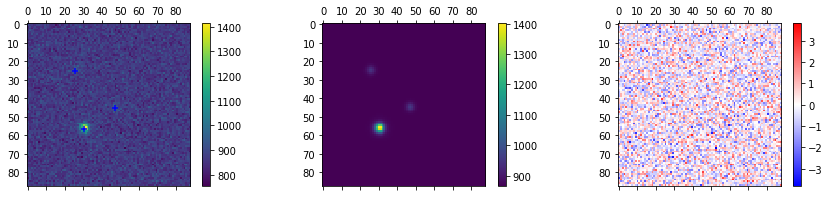

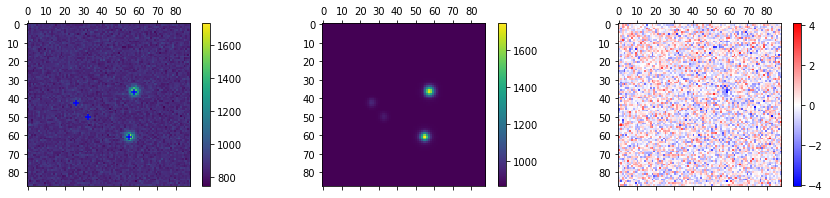

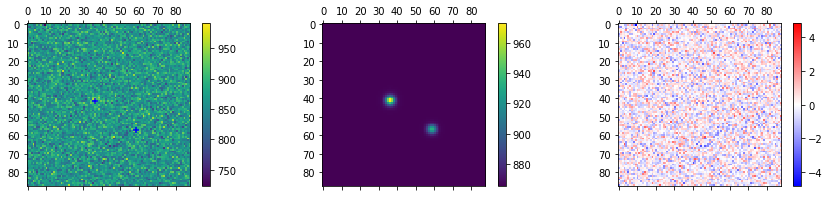

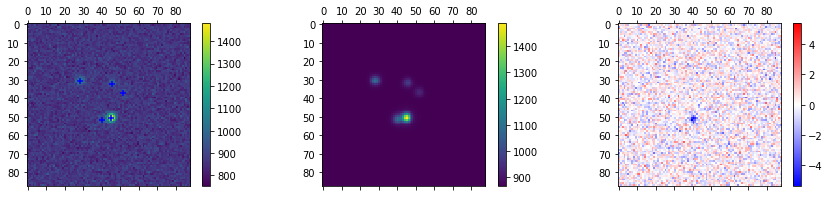

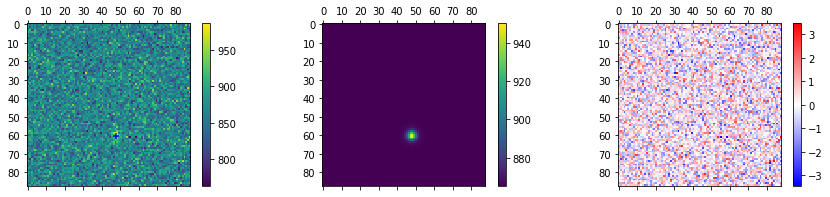

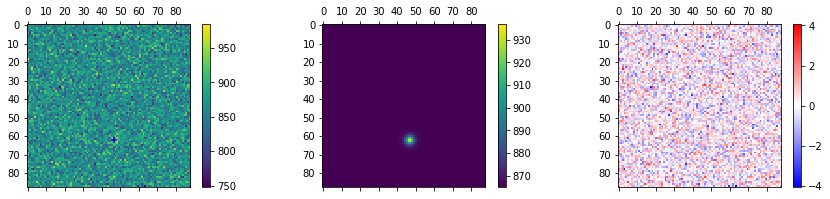

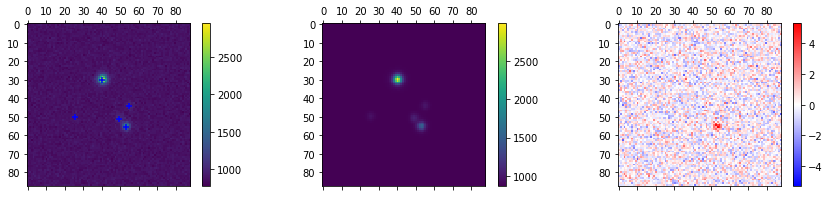

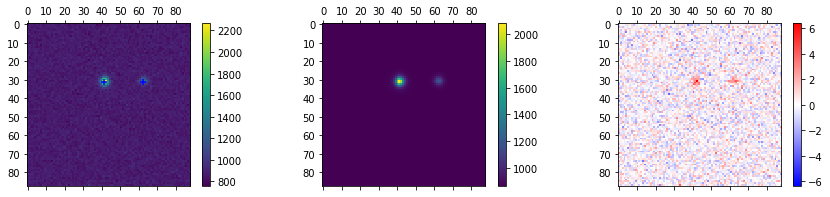

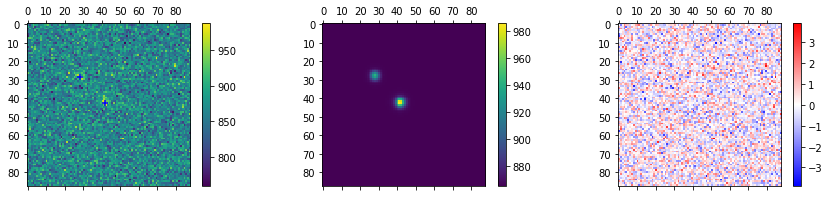

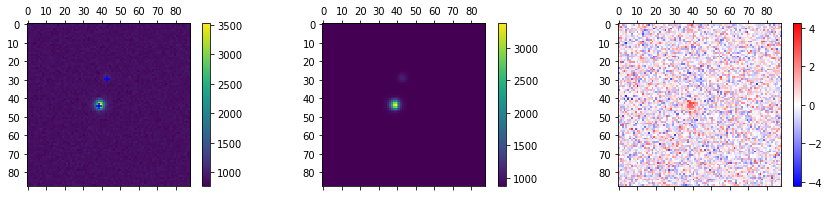

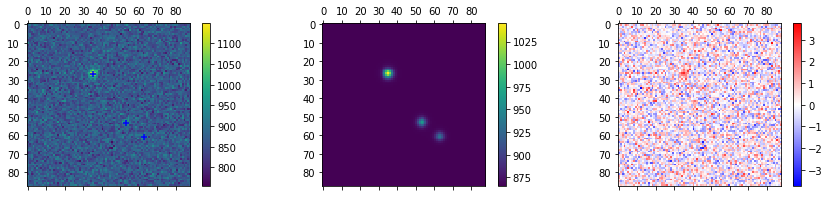

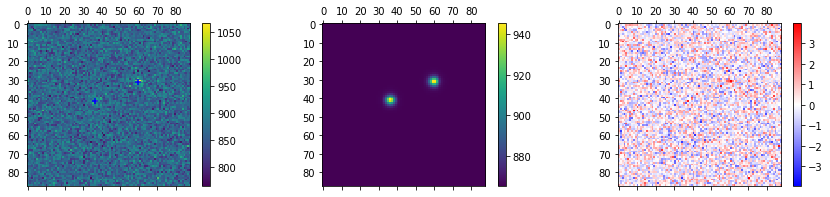

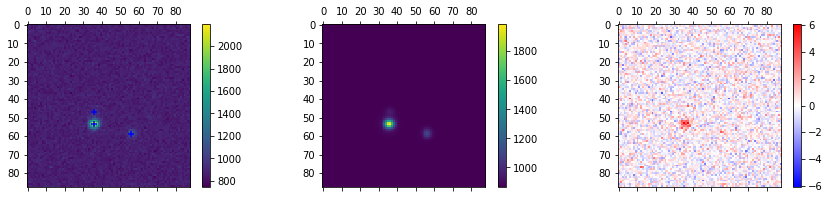

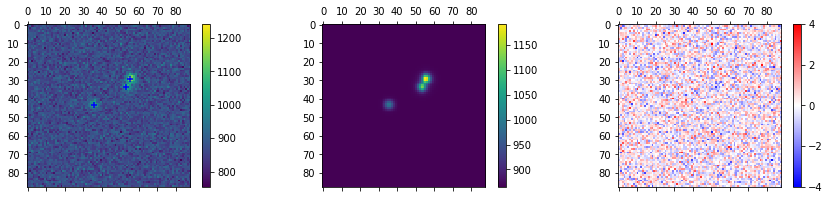

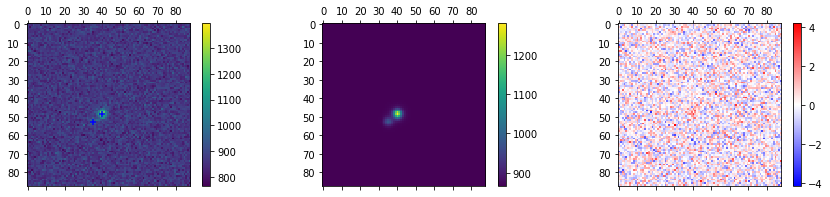

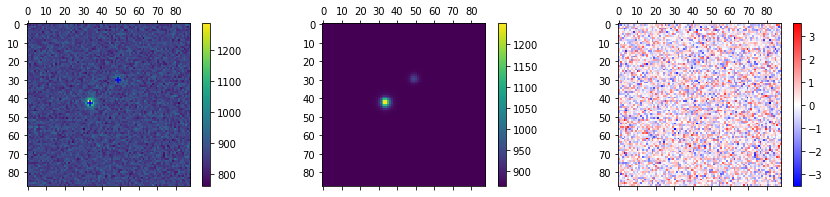

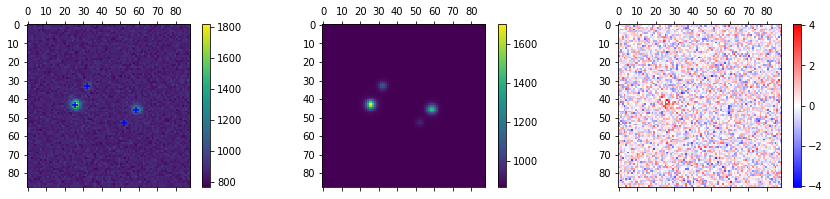

In [25]:
for indx in range(20):

    fig, ax = plotting_utils.plot_residuals(test_batch['images'][indx, 0], 
                                            recon[indx, 0], 
                                            resid_fun=lambda x, y : (x - y) / torch.sqrt(y))
    
    # plot parameters
    plot_params(true_params, indx, ax[0])

### Compare fluxes

In [26]:
truth = []
est = []
sd = []

for _, batch in enumerate(test_dataloader):
    
    # get estimates
    out = flux_estimator(batch['images'])
    
    is_star = get_star_bool(batch['n_sources'], batch['galaxy_bool']) == 1

    _truth = batch['fluxes'][is_star].cpu().numpy()
    _est = out['mean'][is_star].cpu().detach().numpy()
    _sd = out['sd'][is_star].cpu().detach().numpy()
    
    truth.append(_truth)
    est.append(_est)
    sd.append(_sd)
    
truth = np.concatenate(truth)
est = np.concatenate(est)
sd = np.concatenate(sd)

tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)
tensor(0.0829, device='cuda:4', grad_fn=<MinBackward1>)


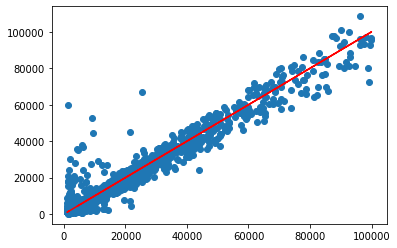

In [27]:
plt.scatter(truth, est)

plt.plot(truth, truth, color = 'red')

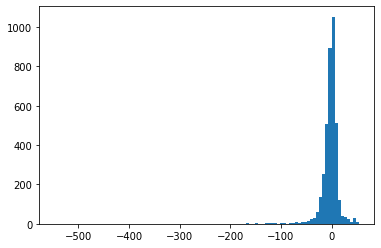

In [28]:
zscore = (est - truth) / sd

plt.hist(zscore, bins = 100);

(array([2955.,  388.,  172.,  111.,   68.,   43.,   39.,   25.,   15.,
           4.]),
 array([   2.1215098,  200.60522  ,  399.08893  ,  597.57263  ,
         796.05634  ,  994.54004  , 1193.0238   , 1391.5074   ,
        1589.9912   , 1788.4749   , 1986.9586   ], dtype=float32),
 <BarContainer object of 10 artists>)

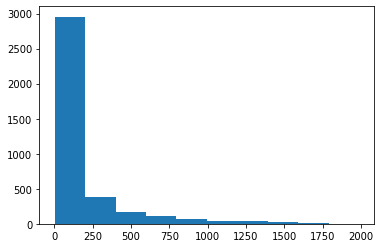

In [29]:
plt.hist(sd)

In [30]:
# trainer.save_checkpoint('../../models/flux_net.ckpt')